In [1]:
import os
import cv2
import glob
import PIL
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from skimage import data
from skimage.util import montage 
import skimage.transform as skTrans
from skimage.transform import rotate
from skimage.transform import resize
from PIL import Image, ImageOps  

from tensorflow.keras.layers import SpatialDropout3D
import nilearn as nl
import nibabel as nib
import nilearn.plotting as nlplt
!pip install git+https://github.com/miykael/gif_your_nifti # nifti to gif 
import gif_your_nifti.core as gif2nif

import keras
import keras.backend as K
from keras.callbacks import CSVLogger
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard

np.set_printoptions(precision=3, suppress=True)

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


  Cloning https://github.com/miykael/gif_your_nifti to /tmp/pip-req-build-1eug0d97
  Running command git clone --filter=blob:none --quiet https://github.com/miykael/gif_your_nifti /tmp/pip-req-build-1eug0d97
  Resolved https://github.com/miykael/gif_your_nifti to commit 55c09c42921f4871cf43f63a303ab420a92a4f03
  Preparing metadata (setup.py) ... done
  Created wheel for gif_your_nifti: filename=gif_your_nifti-0.2.2-py3-none-any.whl size=6633 sha256=1f44717eb617d3f670bfe31798252934d55121b33c5f306b64f0173c9c48b775
  Stored in directory: /tmp/pip-ephem-wheel-cache-9ryz_kmb/wheels/3a/c2/0b/c08f2425925519bb014e107d2919dadc2556ec5e7c205e4472
Successfully built gif_your_nifti


In [2]:
SEGMENT_CLASSES = {
    0 : 'NOT tumor',
    1 : 'NECROTIC/CORE',
    2 : 'EDEMA',
    3 : 'ENHANCING' 
}

VOLUME_SLICES = 100 
VOLUME_START_AT = 22 

Text(0.5, 1.0, 'Mask')

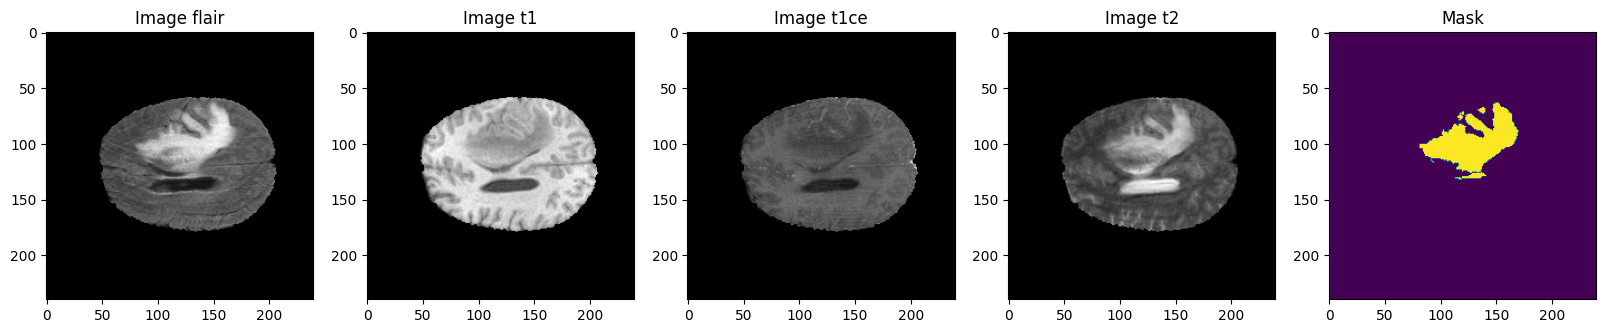

In [3]:
TRAIN_DATASET_PATH = '../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'
VALIDATION_DATASET_PATH = '../input/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData'

test_image_flair=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_flair.nii').get_fdata()
test_image_t1=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_t1.nii').get_fdata()
test_image_t1ce=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_t1ce.nii').get_fdata()
test_image_t2=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_t2.nii').get_fdata()
test_mask=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_seg.nii').get_fdata()


fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize = (20, 10))
slice_w = 25
ax1.imshow(test_image_flair[:,:,test_image_flair.shape[0]//2-slice_w], cmap = 'gray')
ax1.set_title('Image flair')
ax2.imshow(test_image_t1[:,:,test_image_t1.shape[0]//2-slice_w], cmap = 'gray')
ax2.set_title('Image t1')
ax3.imshow(test_image_t1ce[:,:,test_image_t1ce.shape[0]//2-slice_w], cmap = 'gray')
ax3.set_title('Image t1ce')
ax4.imshow(test_image_t2[:,:,test_image_t2.shape[0]//2-slice_w], cmap = 'gray')
ax4.set_title('Image t2')
ax5.imshow(test_mask[:,:,test_mask.shape[0]//2-slice_w])
ax5.set_title('Mask')

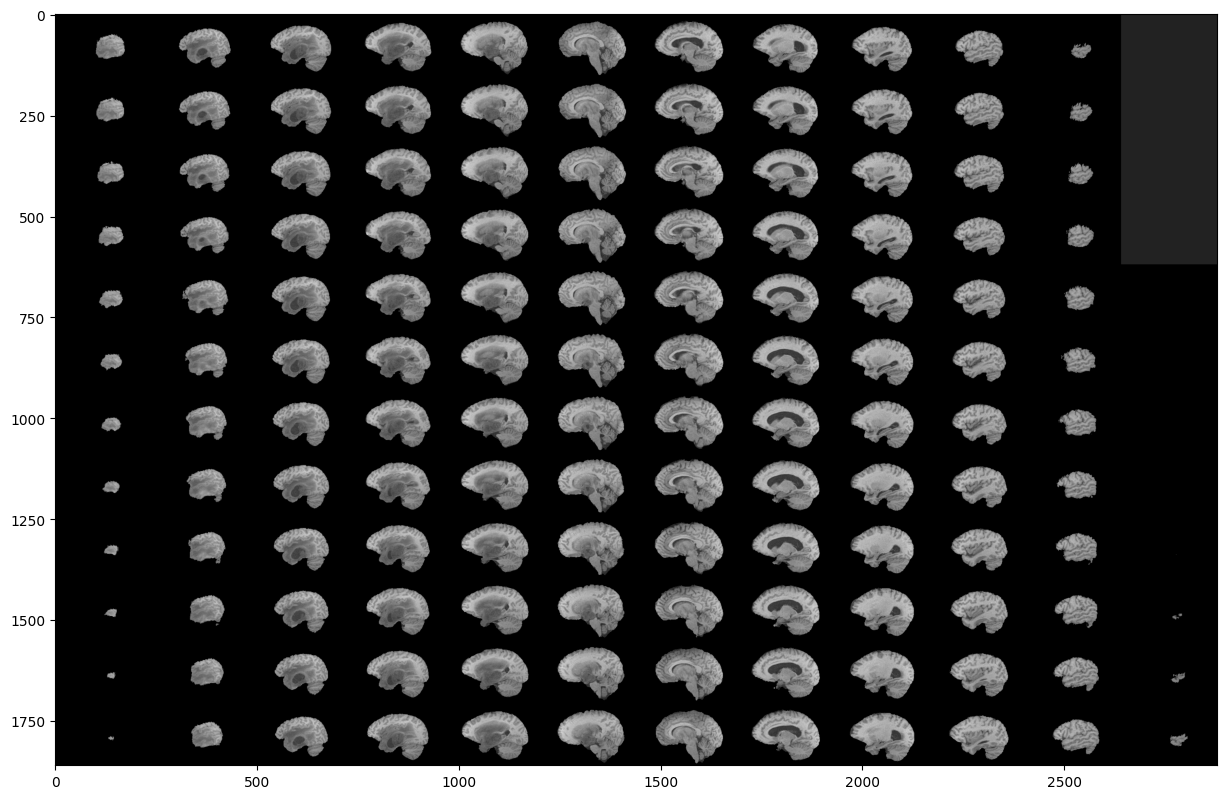

In [58]:
fig, ax1 = plt.subplots(1, 1, figsize = (15,15))
ax1.imshow(rotate(montage(test_image_t1[50:-50,:,:]), 90, resize=True), cmap ='gray')

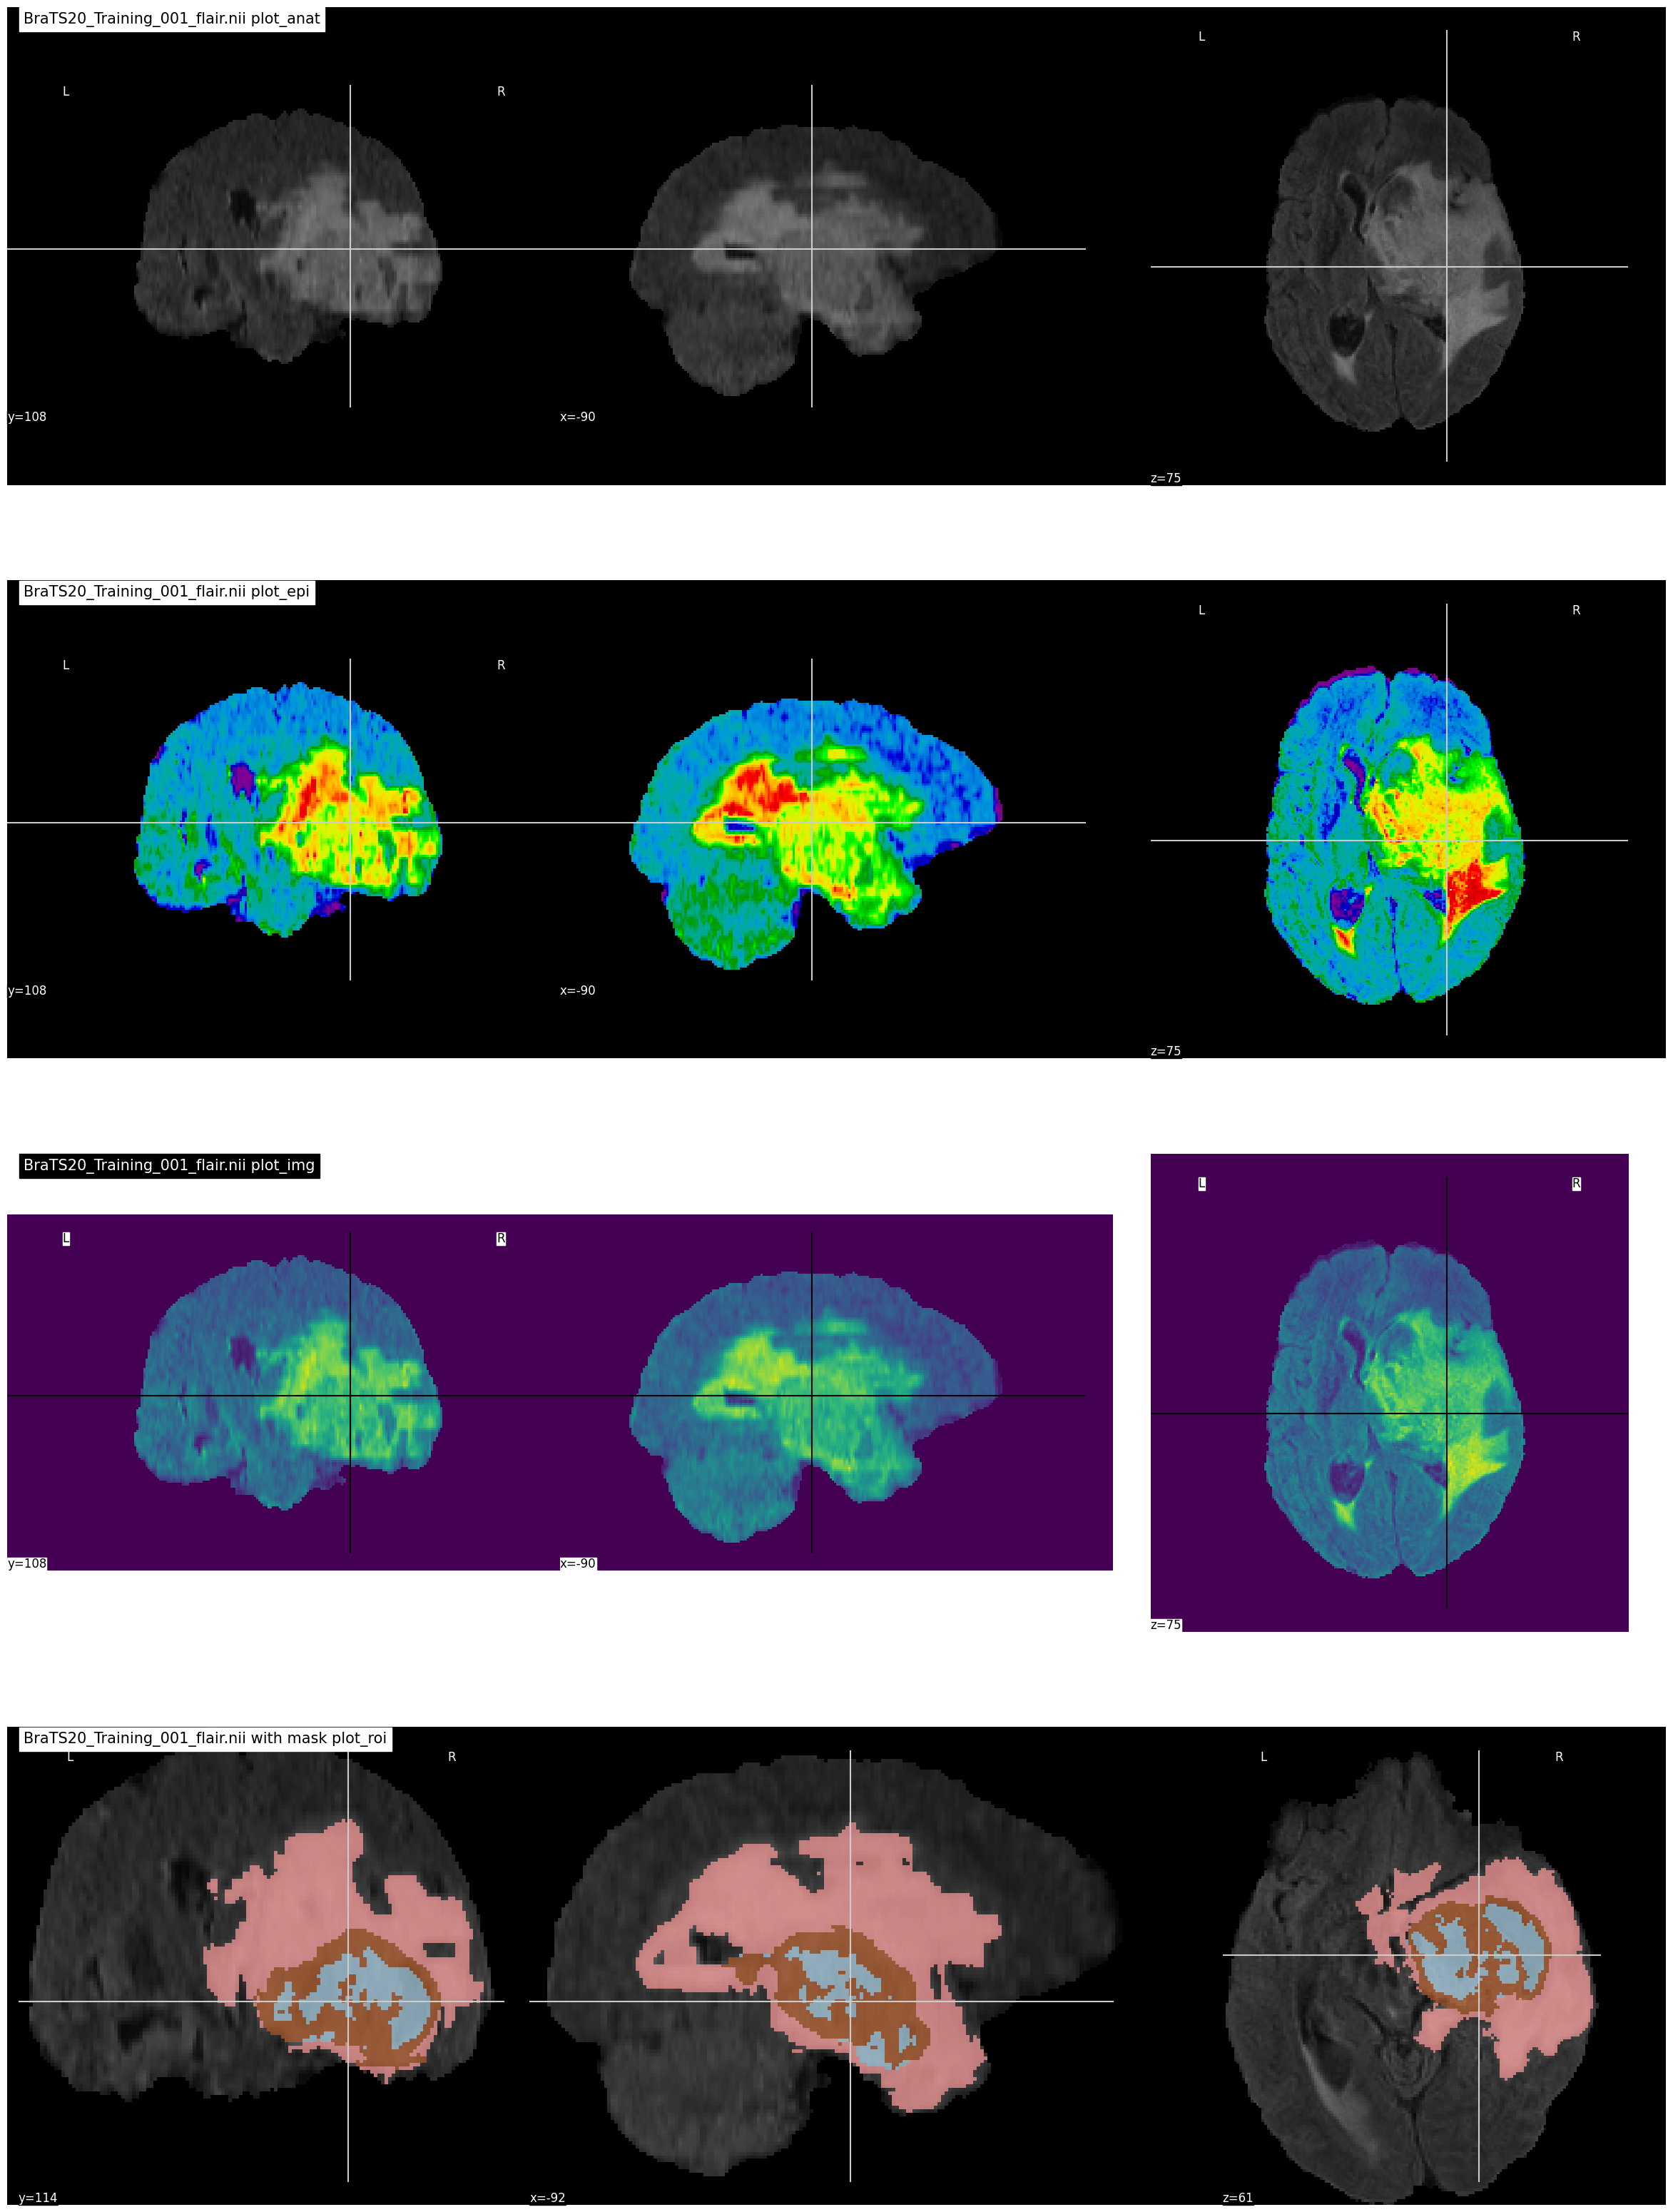

In [5]:
niimg = nl.image.load_img(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_flair.nii')
nimask = nl.image.load_img(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_seg.nii')

fig, axes = plt.subplots(nrows=4, figsize=(30, 40))


nlplt.plot_anat(niimg,
                title='BraTS20_Training_001_flair.nii plot_anat',
                axes=axes[0])

nlplt.plot_epi(niimg,
               title='BraTS20_Training_001_flair.nii plot_epi',
               axes=axes[1])

nlplt.plot_img(niimg,
               title='BraTS20_Training_001_flair.nii plot_img',
               axes=axes[2])

nlplt.plot_roi(nimask, 
               title='BraTS20_Training_001_flair.nii with mask plot_roi',
               bg_img=niimg, 
               axes=axes[3], cmap='Paired')

plt.show()

In [6]:
IMG_SIZE=128

In [7]:
import tensorflow as tf
from tensorflow.keras import backend as K

def dice_coef(y_true, y_pred, smooth=1.0):
    class_num = 4
    total_dice = 0
    for i in range(class_num):
        y_true_f = tf.reshape(y_true[:,:,:,i], [-1])
        y_pred_f = tf.reshape(y_pred[:,:,:,i], [-1])
        intersection = tf.reduce_sum(y_true_f * y_pred_f)
        dice = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
        total_dice += dice
    return total_dice / class_num

def dice_coef_necrotic(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(y_true[:,:,:,1], [-1])
    y_pred_f = tf.reshape(y_pred[:,:,:,1], [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def dice_coef_edema(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(y_true[:,:,:,2], [-1])
    y_pred_f = tf.reshape(y_pred[:,:,:,2], [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def dice_coef_enhancing(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(y_true[:,:,:,3], [-1])
    y_pred_f = tf.reshape(y_pred[:,:,:,3], [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def precision(y_true, y_pred):
    true_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true * y_pred, 0, 1)))
    predicted_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def sensitivity(y_true, y_pred):
    true_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true * y_pred, 0, 1)))
    possible_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

def specificity(y_true, y_pred):
    true_negatives = tf.reduce_sum(tf.round(tf.clip_by_value((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = tf.reduce_sum(tf.round(tf.clip_by_value(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

def combined_loss(y_true, y_pred):
    dice=1-dice_coef(y_true, y_pred)
    crossentropy=tf.keras.losses.categorical_crossentropy(y_true, y_pred)
    return 0.5*dice + 0.5*crossentropy



In [9]:
from tensorflow.keras.layers import Layer, Conv3D, Multiply, Activation, Add

class SpatialAttention(Layer):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.kernel_size = kernel_size
    
    def build(self, input_shape):
        self.conv = Conv3D(1, (self.kernel_size, self.kernel_size, self.kernel_size), padding='same', activation='sigmoid', use_bias=False)
        super(SpatialAttention, self).build(input_shape)
    
    def call(self, inputs):
        attention_map = self.conv(inputs)
        
        output = Multiply()([inputs, attention_map])
        
        return output

In [ ]:
def build_unet(inputs, ker_init, dropout):
    conv1 = Conv3D(32, (3, 3, 3), activation='relu', padding='same', kernel_initializer=ker_init)(inputs)
    conv1 = Conv3D(32, (3, 3, 3), activation='relu', padding='same', kernel_initializer=ker_init)(conv1)
    
    conv1 = SpatialAttention()(conv1)

    pool = MaxPooling3D(pool_size=(2, 2, 2))(conv1)
    conv = Conv3D(64, (3, 3, 3), activation='relu', padding='same', kernel_initializer=ker_init)(pool)
    conv = Conv3D(64, (3, 3, 3), activation='relu', padding='same', kernel_initializer=ker_init)(conv)
    
    conv = SpatialAttention()(conv)
    
    pool1 = MaxPooling3D(pool_size=(2, 2, 2))(conv)
    conv2 = Conv3D(128, (3, 3, 3), activation='relu', padding='same', kernel_initializer=ker_init)(pool1)
    conv2 = Conv3D(128, (3, 3, 3), activation='relu', padding='same', kernel_initializer=ker_init)(conv2)
    
    conv2 = SpatialAttention()(conv2)
    
    pool2 = MaxPooling3D(pool_size=(2, 2, 2))(conv2)
    conv3 = Conv3D(256, (3, 3, 3), activation='relu', padding='same', kernel_initializer=ker_init)(pool2)
    conv3 = Conv3D(256, (3, 3, 3), activation='relu', padding='same', kernel_initializer=ker_init)(conv3)
    
    conv3 = SpatialAttention()(conv3)

    pool4 = MaxPooling3D(pool_size=(2, 2, 2))(conv3)
    conv5 = Conv3D(512, (3, 3, 3), activation='relu', padding='same', kernel_initializer=ker_init)(pool4)
    conv5 = Conv3D(512, (3, 3, 3), activation='relu', padding='same', kernel_initializer=ker_init)(conv5)
    drop5 = SpatialDropout3D(dropout)(conv5)

    up7 = Conv3D(256, (2, 2, 2), activation='relu', padding='same', kernel_initializer=ker_init)(UpSampling3D(size=(2, 2, 2))(drop5))
    merge7 = concatenate([conv3, up7])
    conv7 = Conv3D(256, (3, 3, 3), activation='relu', padding='same', kernel_initializer=ker_init)(merge7)
    conv7 = Conv3D(256, (3, 3, 3), activation='relu', padding='same', kernel_initializer=ker_init)(conv7)

    # Apply spatial attention to conv7
    conv7 = SpatialAttention()(conv7)

    up8 = Conv3D(128, (2, 2, 2), activation='relu', padding='same', kernel_initializer=ker_init)(UpSampling3D(size=(2, 2, 2))(conv7))
    merge8 = concatenate([conv2, up8])
    conv8 = Conv3D(128, (3, 3, 3), activation='relu', padding='same', kernel_initializer=ker_init)(merge8)
    conv8 = Conv3D(128, (3, 3, 3), activation='relu', padding='same', kernel_initializer=ker_init)(conv8)

    # Apply spatial attention to conv8
    conv8 = SpatialAttention()(conv8)

    up9 = Conv3D(64, (2, 2, 2), activation='relu', padding='same', kernel_initializer=ker_init)(UpSampling3D(size=(2, 2, 2))(conv8))
    merge9 = concatenate([conv, up9])
    conv9 = Conv3D(64, (3, 3, 3), activation='relu', padding='same', kernel_initializer=ker_init)(merge9)
    conv9 = Conv3D(64, (3, 3, 3), activation='relu', padding='same', kernel_initializer=ker_init)(conv9)

    # Apply spatial attention to conv9
    conv9 = SpatialAttention()(conv9)

    up = Conv3D(32, (2, 2, 2), activation='relu', padding='same', kernel_initializer=ker_init)(UpSampling3D(size=(2, 2, 2))(conv9))
    merge = concatenate([conv1, up])
    conv = Conv3D(32, (3, 3, 3), activation='relu', padding='same', kernel_initializer=ker_init)(merge)
    conv = Conv3D(32, (3, 3, 3), activation='relu', padding='same', kernel_initializer=ker_init)(conv)

    conv10 = Conv3D(4, (1, 1, 1), activation='softmax')(conv)

    return Model(inputs=inputs, outputs=conv10)


In [ ]:
def combined_loss(y_true, y_pred):
    crossentropy=tf.keras.losses.categorical_cross_entropy
    dice=1-dice_coefficient(y_true, y_pred)
    return combined_loss

In [12]:

input_layer = Input((IMG_SIZE, IMG_SIZE, IMG_SIZE, 3))
model = build_unet(input_layer, 'he_normal', 0.2)
model.compile(
    loss=combined_loss,
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001),
    metrics=[
        'accuracy',
        tf.keras.metrics.MeanIoU(num_classes=4),
        dice_coef,
        precision,
        sensitivity,
        specificity,
        dice_coef_necrotic,
        dice_coef_edema,
        dice_coef_enhancing
    ]
)

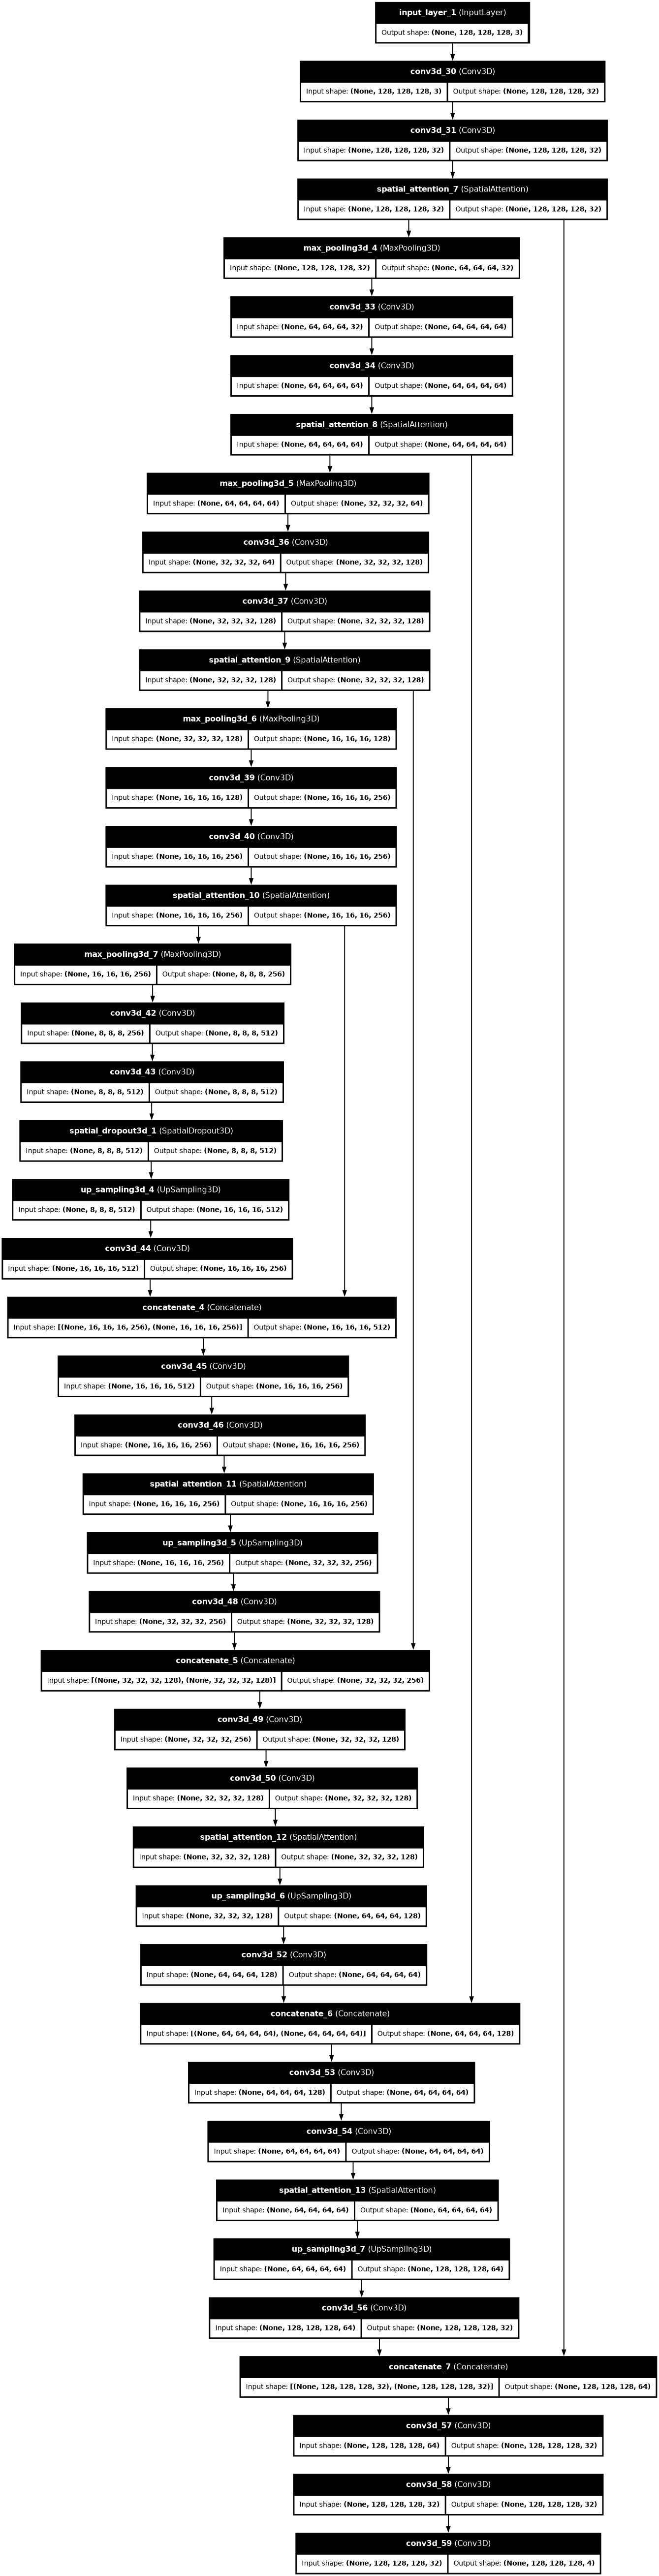

In [13]:
plot_model(model, 
           show_shapes = True,
           show_dtype=False,
           show_layer_names = True, 
           rankdir = 'TB', 
           expand_nested = False, 
           dpi = 70)

In [14]:
train_and_val_directories = [f.path for f in os.scandir(TRAIN_DATASET_PATH) if f.is_dir()]

train_and_val_directories.remove(TRAIN_DATASET_PATH+'BraTS20_Training_355')


def pathListIntoIds(dirList):
    x = []
    for i in range(0,len(dirList)):
        x.append(dirList[i][dirList[i].rfind('/')+1:])
    return x

train_and_test_ids = pathListIntoIds(train_and_val_directories); 

    
train_test_ids, val_ids = train_test_split(train_and_test_ids,test_size=0.2) 
train_ids, test_ids = train_test_split(train_test_ids,test_size=0.15) 

In [15]:
import numpy as np
import tensorflow as tf
import keras
import cv2
import nibabel as nib
import os

class DataGenerator(keras.utils.Sequence):
    def __init__(self, list_IDs, batch_size=1, dim=(240, 240, 50), 
                 n_channels=3, shuffle=True, data_path=''):
        """Initialize DataGenerator.
        
        Args:
            list_IDs: List of sample IDs
            batch_size: Size of each batch
            dim: Dimensions of input image
            n_channels: Number of input channels
            shuffle: Whether to shuffle data between epochs
            data_path: Base path to dataset
        """
        super().__init__()
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.data_path = data_path
        self.on_epoch_end()

    def on_epoch_end(self):
        """Updates indexes after each epoch."""
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __len__(self):
        """Returns the number of batches per epoch."""
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        """Generate one batch of data."""
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]


        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def __data_generation(self, batch_ids):
        """Generates data containing batch_size samples."""
        X = np.zeros((self.batch_size, *self.dim, self.n_channels), dtype=np.float32)
        y = np.zeros((self.batch_size, *self.dim, 4), dtype=np.float32)
        
        for c, ID in enumerate(batch_ids):
            case_path = os.path.join(self.data_path, ID)

            flair = nib.load(os.path.join(case_path, f'{ID}_flair.nii')).get_fdata()
            t1ce = nib.load(os.path.join(case_path, f'{ID}_t1ce.nii')).get_fdata()
            t1 = nib.load(os.path.join(case_path, f'{ID}_t1.nii')).get_fdata()
            seg = nib.load(os.path.join(case_path, f'{ID}_seg.nii')).get_fdata()

            for j in range(self.dim[2]):  # Assuming dim[2] is the number of slices
                X[c, :, :, j, 0] = cv2.resize(flair[:, :, j], (self.dim[0], self.dim[1]))
                X[c, :, :, j, 1] = cv2.resize(t1ce[:, :, j], (self.dim[0], self.dim[1]))
                X[c, :, :, j, 2] = cv2.resize(t1[:, :, j], (self.dim[0], self.dim[1]))

                # Handle segmentation mask
                temp_seg = cv2.resize(seg[:, :, j], (self.dim[0], self.dim[1]), 
                                   interpolation=cv2.INTER_NEAREST)
                temp_seg[temp_seg == 4] = 3  # Convert label 4 to 3
                mask = tf.cast(tf.one_hot(temp_seg.astype(np.int32), 4), tf.float32)
                y[c, :, :, j] = mask

        # Normalize input
        X = X / np.max(X)
        
        return X, y
        
#training_generator = DataGenerator(train_ids)
#valid_generator = DataGenerator(val_ids)
#test_generator = DataGenerator(test_ids)

In [16]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [17]:
callbacks = [
    # Uncomment if needed
    # keras.callbacks.EarlyStopping(monitor='loss', min_delta=0,
    #                               patience=2, verbose=1, mode='auto'),
     keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                               patience=2, min_lr=0.000001, verbose=1),
    # keras.callbacks.ModelCheckpoint(filepath='model_.{epoch:02d}-{val_loss:.6f}.weights.h5',
     #                               verbose=1, save_best_only=True, save_weights_only=True)
]


In [19]:
import tensorflow as tf

strategy = tf.distribute.MirroredStrategy()
print(f'Number of devices: {strategy.num_replicas_in_sync}')

with strategy.scope():
    input_layer = Input((IMG_SIZE, IMG_SIZE, IMG_SIZE, 3))
    model = build_unet(input_layer, 'he_normal', 0.2)
    model.compile(
        loss=combined_loss,
        optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001),
        metrics=[
            'accuracy',
            tf.keras.metrics.MeanIoU(num_classes=4),
            dice_coef,
            precision,
            sensitivity,
            specificity,
            dice_coef_necrotic,
            dice_coef_edema,
            dice_coef_enhancing
        ]
    )


BATCH_SIZE_PER_GPU = 1
global_batch_size = BATCH_SIZE_PER_GPU * strategy.num_replicas_in_sync

training_generator = DataGenerator(
    list_IDs=train_ids,
    batch_size=global_batch_size,
    dim=(IMG_SIZE, IMG_SIZE, IMG_SIZE),
    n_channels=3,
    data_path=TRAIN_DATASET_PATH
)

valid_generator = DataGenerator(
    list_IDs=val_ids,
    batch_size=global_batch_size,
    dim=(IMG_SIZE, IMG_SIZE, IMG_SIZE),
    n_channels=3,
    data_path=TRAIN_DATASET_PATH
)

test_generator = DataGenerator(
    list_IDs=test_ids,
    batch_size=global_batch_size,
    dim=(IMG_SIZE, IMG_SIZE, IMG_SIZE),
    n_channels=3,
    data_path=VALIDATION_DATASET_PATH
)

# Train the model
history = model.fit(
    training_generator,
    epochs=5,
    callbacks=callbacks,
    validation_data=valid_generator
)

Number of devices: 2
Epoch 1/5
124/124 ━━━━━━━━━━━━━━━━━━━━ 593s 5s/step - accuracy: 0.9686 - dice_coef: 0.7539 - dice_coef_edema: 0.7653 - dice_coef_enhancing: 0.7678 - dice_coef_necrotic: 0.7530 - loss: 0.6649 - mean_io_u_2: 0.5488 - precision: 0.7985 - sensitivity: 0.6839 - specificity: 0.9969 - val_accuracy: 0.9857 - val_dice_coef: 0.9985 - val_dice_coef_edema: 0.9989 - val_dice_coef_enhancing: 0.9991 - val_dice_coef_necrotic: 0.9985 - val_loss: 0.0651 - val_mean_io_u_2: 0.7073 - val_precision: 0.9905 - val_sensitivity: 0.9414 - val_specificity: 0.9969 - learning_rate: 1.0000e-04
Epoch 2/5
124/124 ━━━━━━━━━━━━━━━━━━━━ 491s 4s/step - accuracy: 0.9866 - dice_coef: 0.9985 - dice_coef_edema: 0.9989 - dice_coef_enhancing: 0.9988 - dice_coef_necrotic: 0.9985 - loss: 0.0591 - mean_io_u_2: 0.7154 - precision: 0.9871 - sensitivity: 0.9757 - specificity: 0.9957 - val_accuracy: 0.9867 - val_dice_coef: 0.9998 - val_dice_coef_edema: 0.9999 - val_dice_coef_enhancing: 0.9999 - val_dice_coef_necro

In [16]:
strategy=tf.distribute.MirroredStrategy

In [165]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import cv2
import os

def predictByPath(model, case_path, case_id):

    X = np.zeros((1, IMG_SIZE, IMG_SIZE, IMG_SIZE, 3))
    
    flair = nib.load(os.path.join(case_path, f'{case_id}_flair.nii')).get_fdata()
    t1ce = nib.load(os.path.join(case_path, f'{case_id}_t1ce.nii')).get_fdata()
    t1 = nib.load(os.path.join(case_path, f'{case_id}_t1.nii')).get_fdata()
    
    for j in range(IMG_SIZE):
        X[0, :, :, j, 0] = cv2.resize(flair[:, :, j], (IMG_SIZE, IMG_SIZE))
        X[0, :, :, j, 1] = cv2.resize(t1ce[:, :, j], (IMG_SIZE, IMG_SIZE))
        X[0, :, :, j, 2] = cv2.resize(t1[:, :, j], (IMG_SIZE, IMG_SIZE))
    
    X = X / np.max(X)
    
    return model.predict(X, verbose=1)

def showPredictsById(model, case_id, data_path, start_slice=64):
    """
    Show predictions for a given case
    
    Args:
        model: Trained 3D U-Net model
        case_id: Case identifier (e.g., 'BraTS20_Training_001')
        data_path: Path to the dataset
        start_slice: Slice index to visualize
    """
    case_path = os.path.join(data_path, case_id)
    
    gt = nib.load(os.path.join(case_path, f'{case_id}_seg.nii')).get_fdata()
    flair = nib.load(os.path.join(case_path, f'{case_id}_flair.nii')).get_fdata()
    
    predictions = predictByPath(model, case_path, case_id)
    
    background = predictions[0, :, :, :, 0]
    necrotic = predictions[0, :, :, :, 1]
    edema = predictions[0, :, :, :, 2]
    enhancing = predictions[0, :, :, :, 3]
    
    plt.figure(figsize=(20, 4))
    
    # Original FLAIR
    plt.subplot(161)
    plt.imshow(cv2.resize(flair[:, :, start_slice], (IMG_SIZE, IMG_SIZE)), cmap="gray")
    plt.title('Original FLAIR')
    plt.axis('off')
    
    # Ground Truth
    plt.subplot(162)
    gt_slice = cv2.resize(gt[:, :, start_slice], (IMG_SIZE, IMG_SIZE), 
                         interpolation=cv2.INTER_NEAREST)
    plt.imshow(cv2.resize(flair[:, :, start_slice], (IMG_SIZE, IMG_SIZE)), cmap="gray")
    plt.imshow(gt_slice, cmap="hot", interpolation='none', alpha=0.3)
    plt.title('Ground Truth')
    plt.axis('off')
    
    # Combined Prediction
    plt.subplot(163)
    combined_pred = np.zeros((IMG_SIZE, IMG_SIZE, 3))
    
    combined_pred[:, :, 0] = necrotic[:, :, start_slice]
    combined_pred[:, :, 1] = edema[:, :, start_slice]
    combined_pred[:, :, 2] = enhancing[:, :, start_slice]
    plt.imshow(cv2.resize(flair[:, :, start_slice], (IMG_SIZE, IMG_SIZE)), cmap="gray")
    plt.imshow(combined_pred, interpolation='none', alpha=0.3)
    plt.title('Combined Prediction')
    plt.axis('off')
    
    # Individual class predictions
    plt.subplot(164)
    plt.imshow(cv2.resize(flair[:, :, start_slice], (IMG_SIZE, IMG_SIZE)), cmap="gray")
    plt.imshow(necrotic[:, :, start_slice], cmap="inferno", interpolation='none', alpha=0.3)
    plt.title(f'{SEGMENT_CLASSES[1]}')
    plt.axis('off')
    
    plt.subplot(165)
    plt.imshow(cv2.resize(flair[:, :, start_slice], (IMG_SIZE, IMG_SIZE)), cmap="gray")
    plt.imshow(edema[:, :, start_slice], cmap="mako", interpolation='none', alpha=0.3)
    plt.title(f'{SEGMENT_CLASSES[2]}')
    plt.axis('off')
    
    plt.subplot(166)
    plt.imshow(cv2.resize(flair[:, :, start_slice], (IMG_SIZE, IMG_SIZE)), cmap="gray")
    plt.imshow(enhancing[:, :, start_slice], cmap="rocket", interpolation='none', alpha=0.3)
    plt.title(f'{SEGMENT_CLASSES[3]}')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Calculate Dice scores
    dice_scores = []
    gt_slice = gt_slice.astype(int)
    pred_slice = np.argmax(predictions[0, :, :, start_slice], axis=-1)
    
    for i in range(1, 4):  
        gt_binary = (gt_slice == i).astype(np.float32)
        pred_binary = (pred_slice == i).astype(np.float32)
        intersection = np.sum(gt_binary * pred_binary)
        union = np.sum(gt_binary) + np.sum(pred_binary)
        if union > 0:
            dice = 2 * intersection / union
        else:
            dice = 1.0 if intersection == 0 else 0.0
        dice_scores.append(dice)
    
    print("\nDice Scores for slice {}:".format(start_slice))
    print(f"Necrotic/Core: {dice_scores[0]:.3f}")
    print(f"Edema: {dice_scores[1]:.3f}")
    print(f"Enhancing: {dice_scores[2]:.3f}")
    print(f"Average: {np.mean(dice_scores):.3f}")


Case BraTS20_Training_180
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step


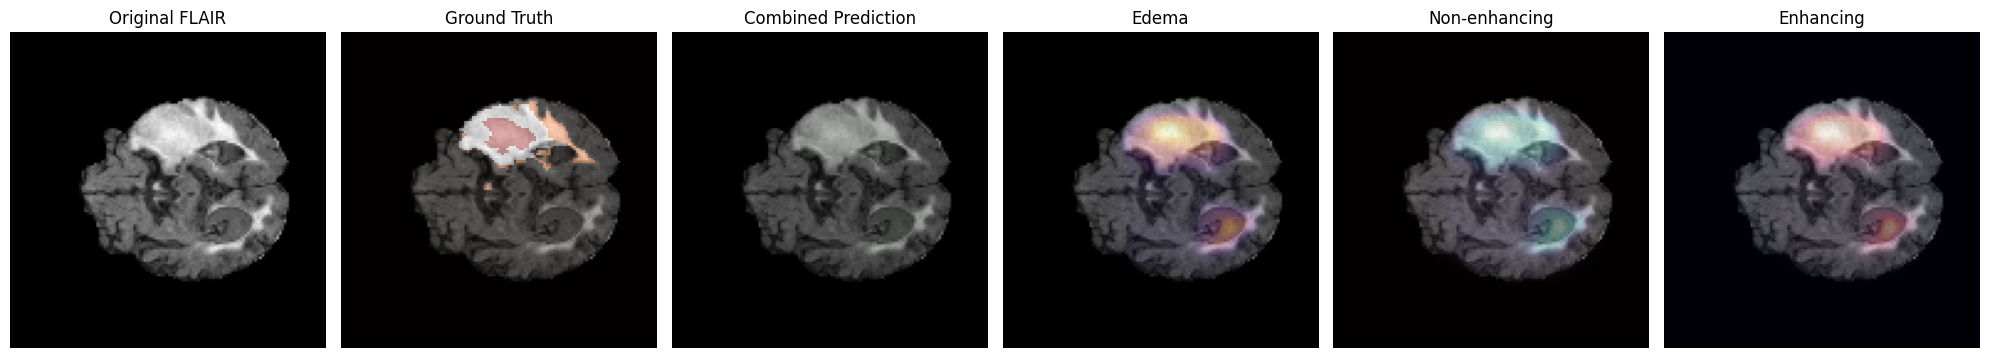


Dice Scores for slice 64:
Necrotic/Core: 0.000
Edema: 0.000
Enhancing: 1.000
Average: 0.333

Case BraTS20_Training_034
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step


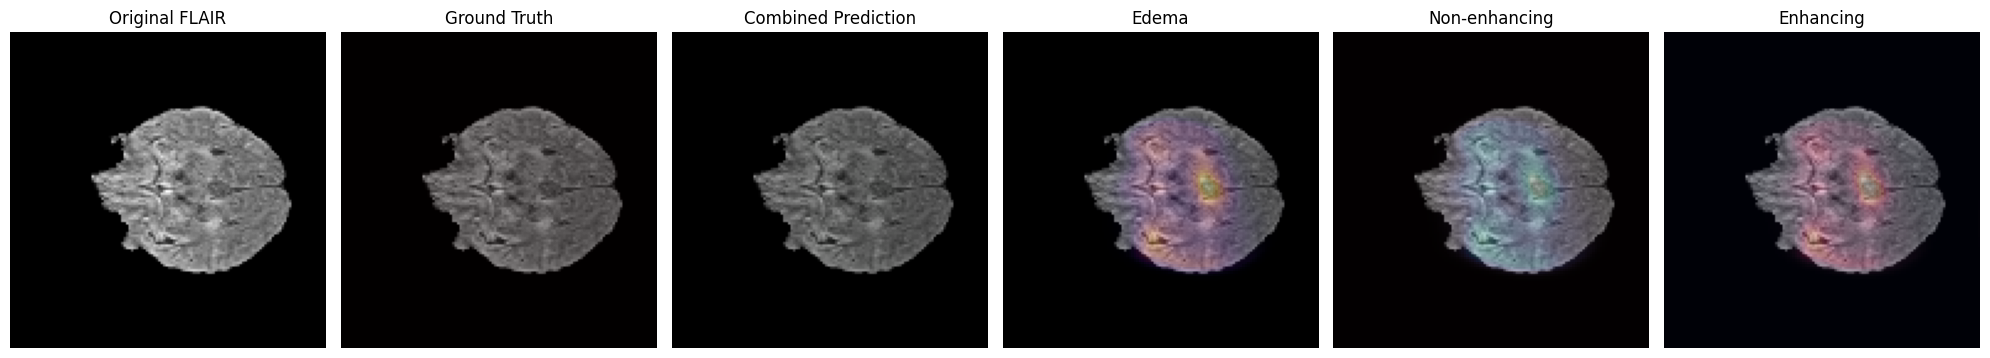


Dice Scores for slice 64:
Necrotic/Core: 1.000
Edema: 1.000
Enhancing: 1.000
Average: 1.000

Case BraTS20_Training_023
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step


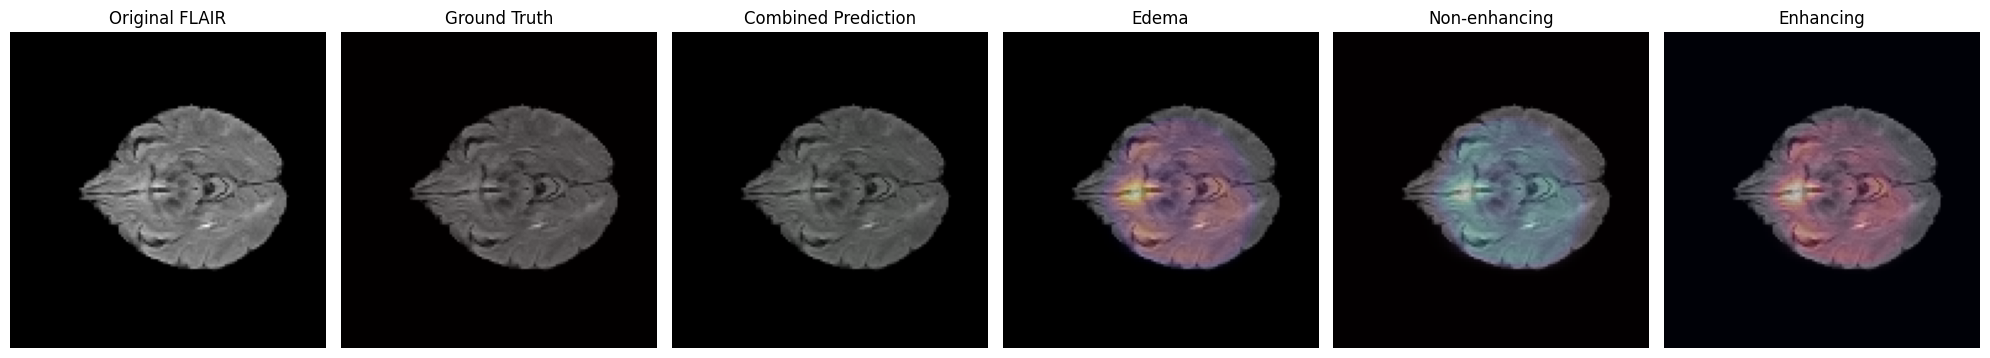


Dice Scores for slice 64:
Necrotic/Core: 1.000
Edema: 1.000
Enhancing: 1.000
Average: 1.000

Case BraTS20_Training_227
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step


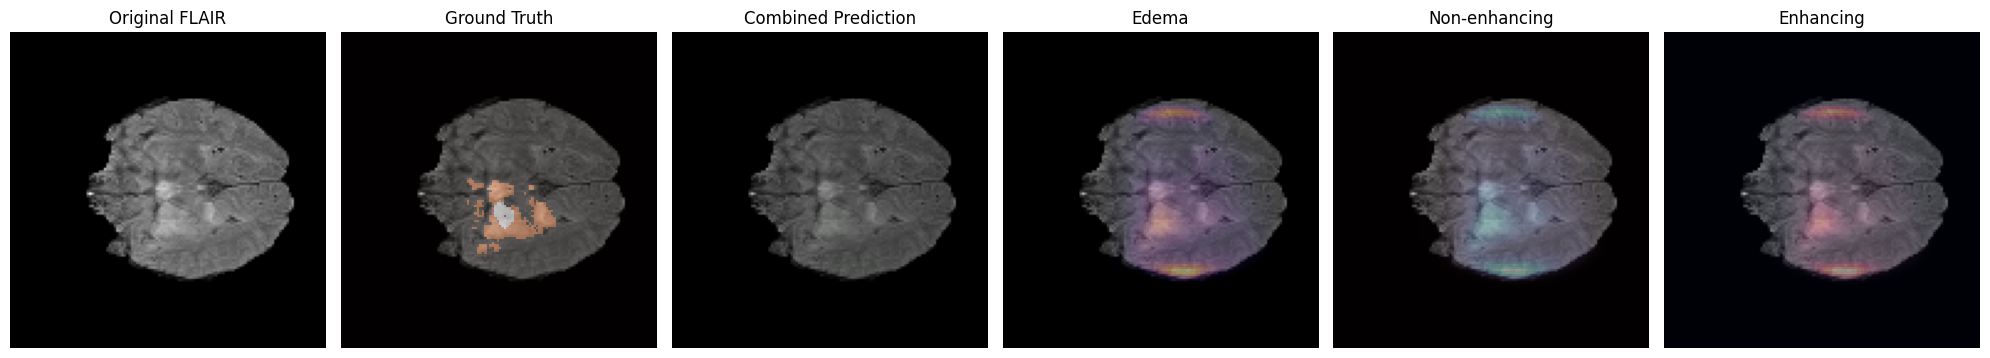


Dice Scores for slice 64:
Necrotic/Core: 0.000
Edema: 0.000
Enhancing: 1.000
Average: 0.333

Case BraTS20_Training_019
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step


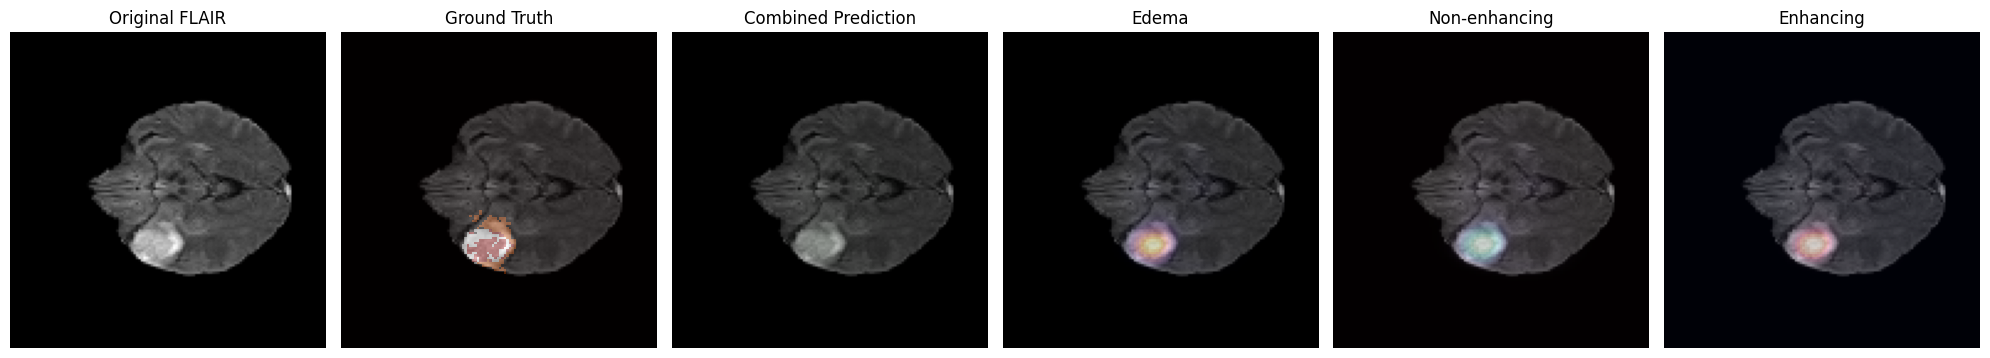


Dice Scores for slice 64:
Necrotic/Core: 0.000
Edema: 0.000
Enhancing: 1.000
Average: 0.333
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step


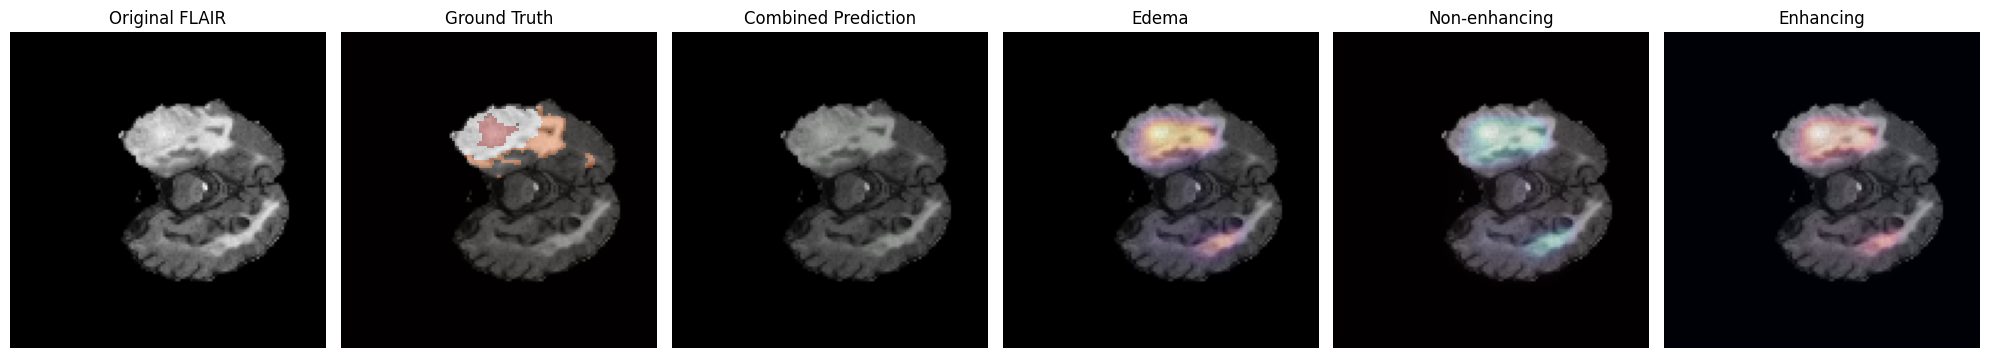


Dice Scores for slice 50:
Necrotic/Core: 0.000
Edema: 0.000
Enhancing: 1.000
Average: 0.333
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step


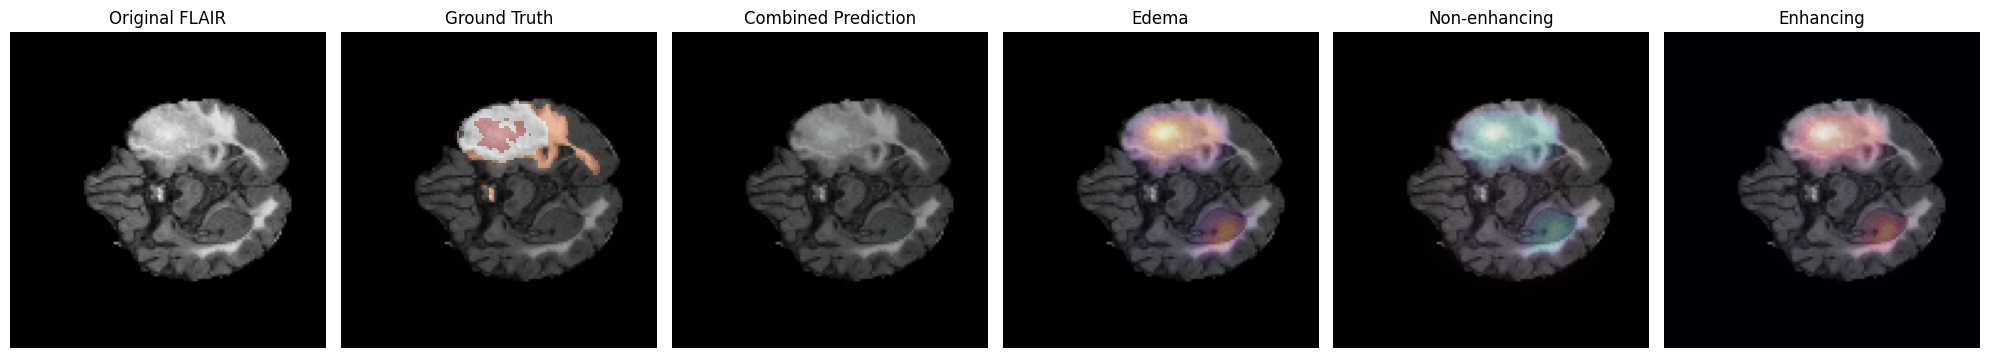


Dice Scores for slice 60:
Necrotic/Core: 0.000
Edema: 0.000
Enhancing: 1.000
Average: 0.333
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step


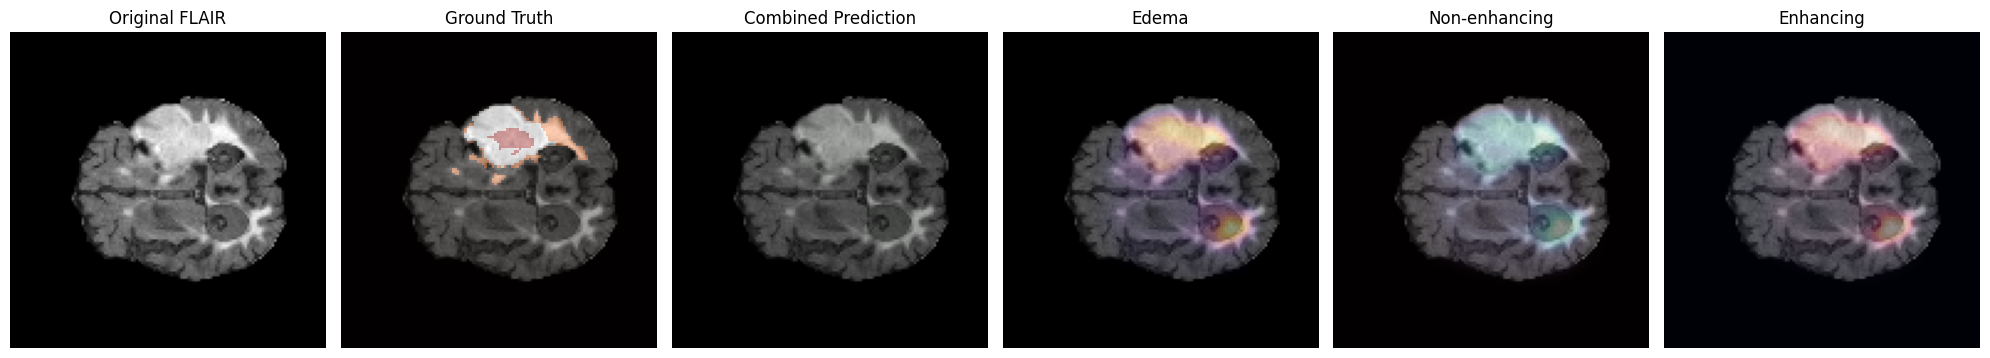


Dice Scores for slice 70:
Necrotic/Core: 0.000
Edema: 0.000
Enhancing: 1.000
Average: 0.333
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step


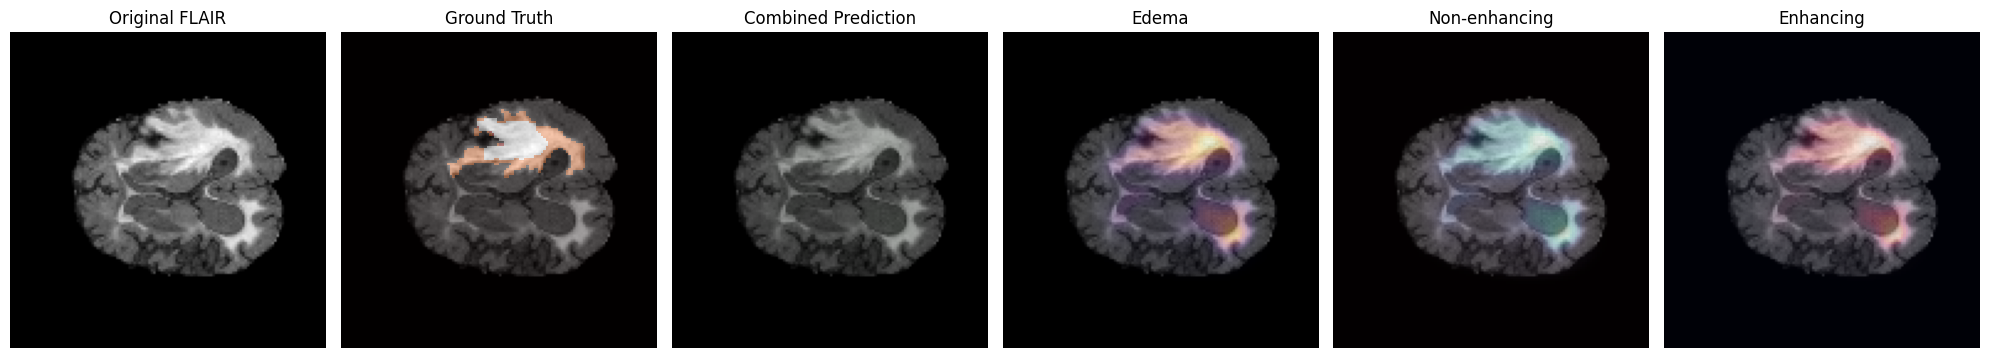


Dice Scores for slice 80:
Necrotic/Core: 0.000
Edema: 0.000
Enhancing: 1.000
Average: 0.333


In [166]:
for i in range(5):  # Show first 5 test cases
    print(f"\nCase {test_ids[i]}")
    showPredictsById(model, test_ids[i], TRAIN_DATASET_PATH)

case_id = test_ids[0]
for slice_idx in [50, 60, 70, 80]:  # View different slices
    showPredictsById(model, case_id, TRAIN_DATASET_PATH, start_slice=slice_idx)

In [50]:
model.save('3d_attention_unet.h5')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 754ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 693ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 693ms/step


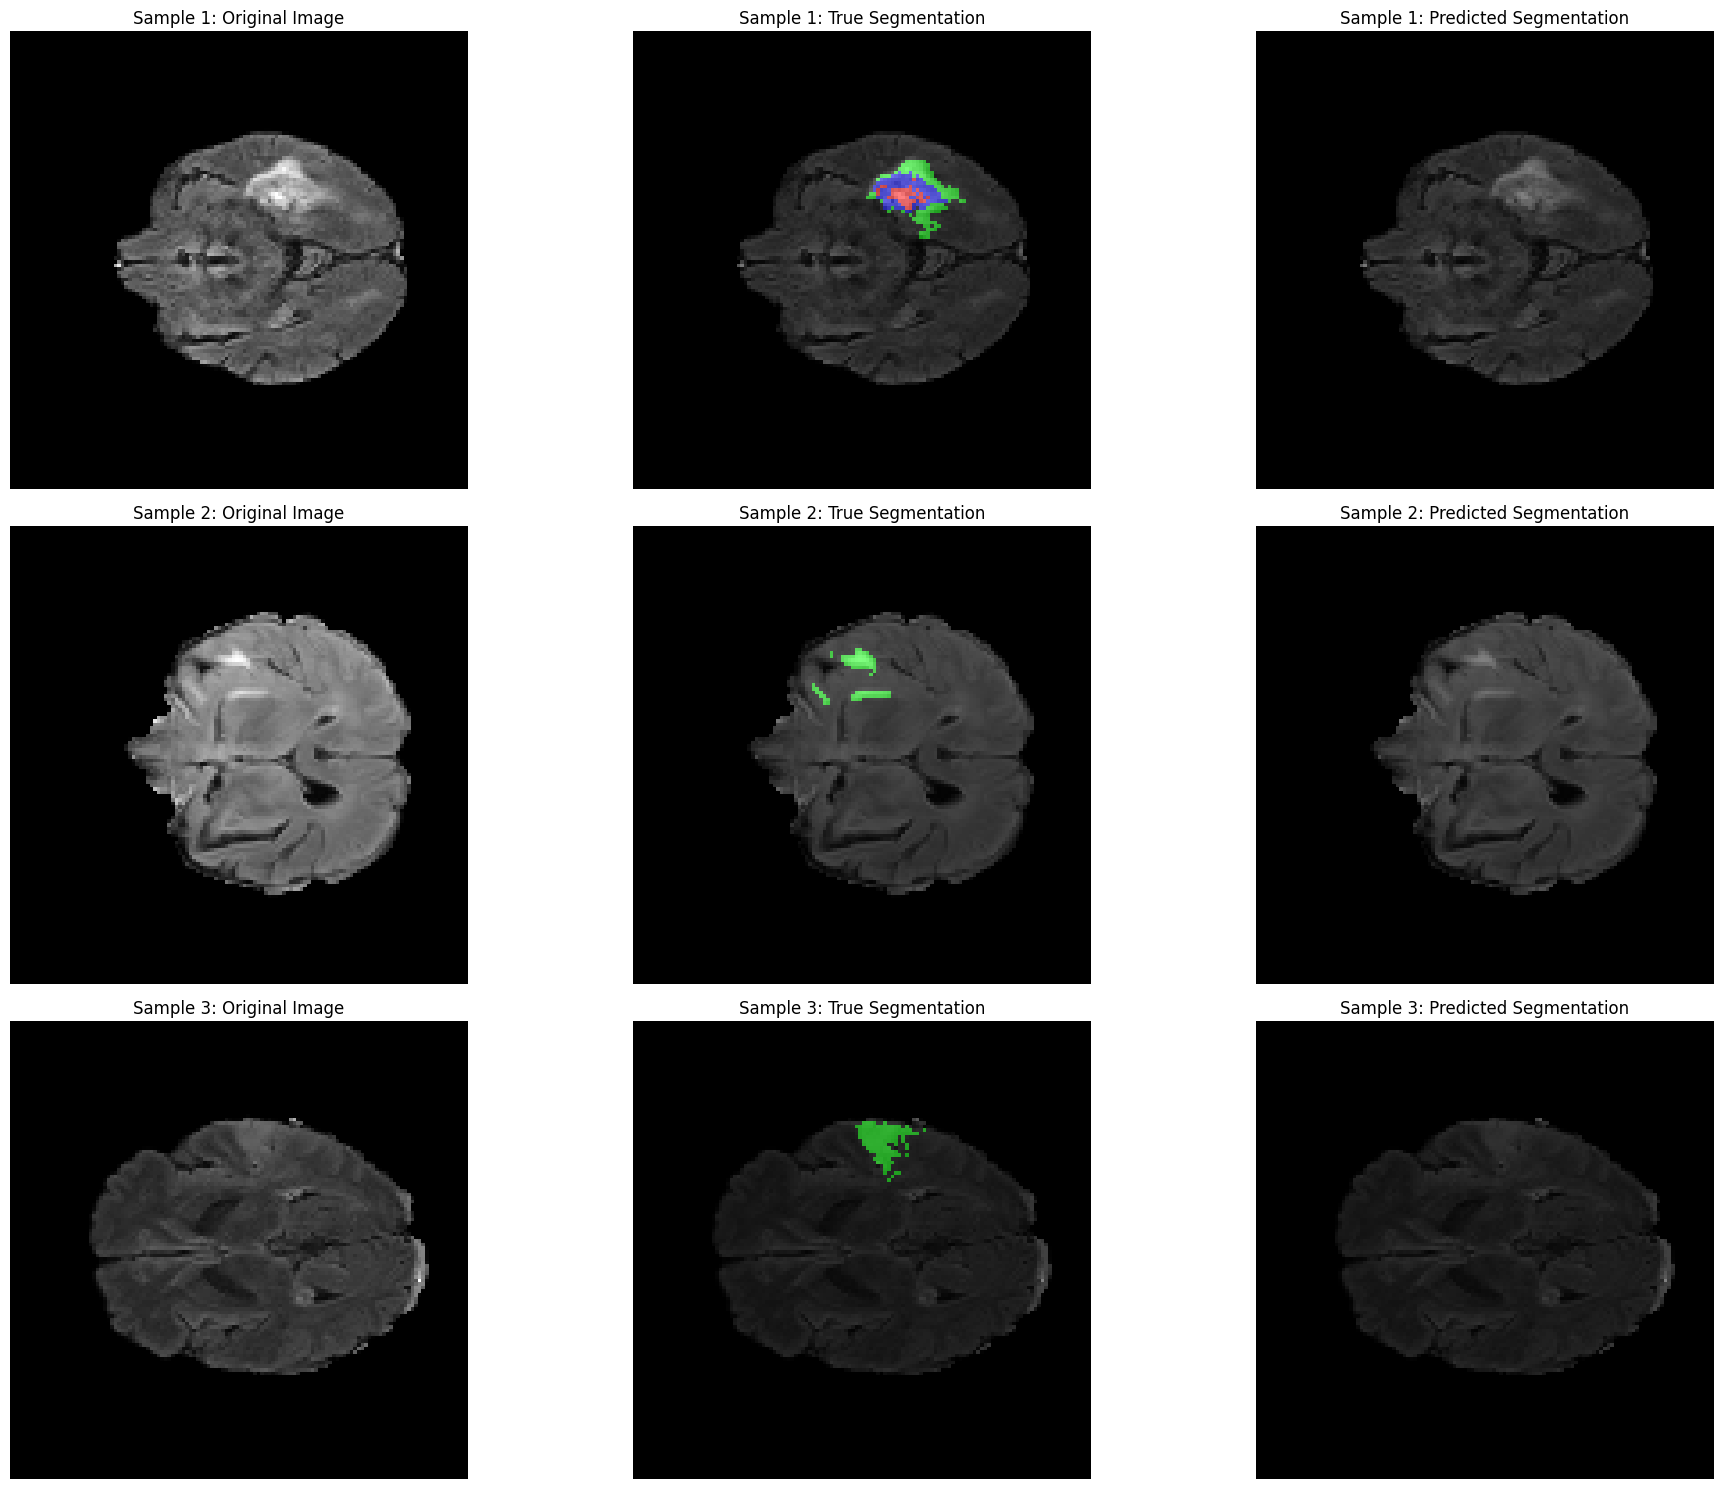

NameError: name 'y_true' is not defined

In [117]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import cv2

def visualize_predictions(model, test_generator, num_samples=3):
    """
    Visualize model predictions for brain tumor segmentation
    """
    plt.figure(figsize=(20, 5*num_samples))
    
    segment_classes = {
        0: 'Background',
        1: 'Necrotic Core',
        2: 'Edema',
        3: 'Enhancing Tumor'
    }
    
    colors = {
        0: [0, 0, 0],       # Black
        1: [255, 0, 0],        # Red
        2: [0, 255, 0],        # Green
        3: [0, 0, 255]         # Blue
    }
    
    for sample in range(num_samples):
        # Get a batch from test generator
        X_batch, batch_y_true = test_generator[sample]
        
        # Predict segmentation
        batch_y_pred = model.predict(X_batch)
        
        # Select first image in batch
        X = X_batch[0]
        y_true = batch_y_true[0]
        y_pred = batch_y_pred[0]
        
        # Argmax to get class predictions
        y_true_classes = np.argmax(y_true, axis=-1)
        y_pred_classes = np.argmax(y_pred, axis=-1)
        
        # Create overlay images
        middle_slice = X.shape[2] // 2
        
        # Original image (using first channel)
        original_img = X[:,:,middle_slice,0]
        
        # Normalize original image
        original_img = (original_img - original_img.min()) / (original_img.max() - original_img.min())
        
        # Create RGB overlay images
        pred_overlay = np.zeros((original_img.shape[0], original_img.shape[1], 3))
        true_overlay = np.zeros((original_img.shape[0], original_img.shape[1], 3))
        
        for cls in range(1, 4):  # Skip background
            pred_mask = (y_pred_classes[:,:,middle_slice] == cls)
            true_mask = (y_true_classes[:,:,middle_slice] == cls)
            
            # Assign color to the masks
            for color_channel in range(3):
                pred_overlay[pred_mask, color_channel] = colors[cls][color_channel]
                true_overlay[true_mask, color_channel] = colors[cls][color_channel]
        
        # Plot results
        plt.subplot(num_samples, 3, sample*3 + 1)
        plt.title(f'Sample {sample+1}: Original Image')
        plt.imshow(original_img, cmap='gray')
        plt.axis('off')
        
        plt.subplot(num_samples, 3, sample*3 + 2)
        plt.title(f'Sample {sample+1}: True Segmentation')
        plt.imshow(original_img, cmap='gray')
        plt.imshow(true_overlay, alpha=0.5)
        plt.axis('off')
        
        plt.subplot(num_samples, 3, sample*3 + 3)
        plt.title(f'Sample {sample+1}: Predicted Segmentation')
        plt.imshow(original_img, cmap='gray')
        plt.imshow(pred_overlay, alpha=0.5)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Usage
visualize_predictions(model, training_generator)

def compute_segmentation_metrics(y_true, y_pred):
    """
    Compute detailed segmentation metrics
    
    Args:
        y_true: Ground truth segmentation mask
        y_pred: Predicted segmentation mask
    
    Returns:
        Dictionary of metrics for each tumor region
    """
    metrics = {}
    segment_classes = ['Background', 'Necrotic Core', 'Edema', 'Enhancing Tumor']
    
    for cls in range(1, 4):
        y_true_cls = (y_true == cls).astype(int)
        y_pred_cls = (y_pred == cls).astype(int)
        
        # Compute metrics
        tp = np.sum((y_true_cls == 1) & (y_pred_cls == 1))
        fp = np.sum((y_true_cls == 0) & (y_pred_cls == 1))
        fn = np.sum((y_true_cls == 1) & (y_pred_cls == 0))
        
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        metrics[segment_classes[cls]] = {
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1_score
        }
    
    return metrics

# Example usage after prediction
y_true_classes = np.argmax(y_true, axis=-1)
y_pred_classes = np.argmax(y_pred, axis=-1)
region_metrics = compute_segmentation_metrics(y_true_classes, y_pred_classes)
print(region_metrics)

In [186]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import cv2
import os

def predictByPath(model, case_path, case_id):
    """
    Predict tumor segmentation for a given case
    
    Args:
        model: Trained 3D U-Net model
        case_path: Path to the case directory
        case_id: Case identifier
    """
    X = np.zeros((1, IMG_SIZE, IMG_SIZE, IMG_SIZE, 3))
    
    flair = nib.load(os.path.join(case_path, f'{case_id}_flair.nii')).get_fdata()
    t1ce = nib.load(os.path.join(case_path, f'{case_id}_t1ce.nii')).get_fdata()
    t1 = nib.load(os.path.join(case_path, f'{case_id}_t1.nii')).get_fdata()
    
    for j in range(IMG_SIZE):
        X[0, :, :, j, 0] = cv2.resize(flair[:, :, j], (IMG_SIZE, IMG_SIZE))
        X[0, :, :, j, 1] = cv2.resize(t1ce[:, :, j], (IMG_SIZE, IMG_SIZE))
        X[0, :, :, j, 2] = cv2.resize(t1[:, :, j], (IMG_SIZE, IMG_SIZE))
    
    X = X / np.max(X)
    
    return model.predict(X, verbose=1)


def showPredictsById(model, case_id, data_path, start_slice=64, threshold=0.1):
    """
    Show predictions for a given case with improved sharpness
    
    Args:
        model: Trained 3D U-Net model
        case_id: Case identifier (e.g., 'BraTS20_Training_001')
        data_path: Path to the dataset
        start_slice: Slice index to visualize
        threshold: Probability threshold for segmentation
    """
    case_path = os.path.join(data_path, case_id)
    
    gt = nib.load(os.path.join(case_path, f'{case_id}_seg.nii')).get_fdata()
    flair = nib.load(os.path.join(case_path, f'{case_id}_flair.nii')).get_fdata()
    
    predictions = predictByPath(model, case_path, case_id)
    
    # Extract predictions and create sharp masks
    background = predictions[0, :, :, :, 0]
    necrotic = predictions[0, :, :, :, 1]
    edema = predictions[0, :, :, :, 2]
    enhancing = predictions[0, :, :, :, 3]
    
    # Create binary masks using a threshold
    necrotic_mask = (necrotic[:, :, start_slice] > threshold).astype(np.uint8)
    edema_mask = (edema[:, :, start_slice] > threshold).astype(np.uint8)
    enhancing_mask = (enhancing[:, :, start_slice] > threshold).astype(np.uint8)
    
    plt.figure(figsize=(20, 6))
    
    # Original FLAIR
    plt.subplot(161)
    plt.imshow(cv2.resize(flair[:, :, start_slice], (IMG_SIZE, IMG_SIZE)), cmap="gray")
    plt.title('Original FLAIR')
    plt.axis('off')
    
    # Ground Truth
    plt.subplot(162)
    gt_slice = cv2.resize(gt[:, :, start_slice], (IMG_SIZE, IMG_SIZE), 
                         interpolation=cv2.INTER_NEAREST)
    plt.imshow(cv2.resize(flair[:, :, start_slice], (IMG_SIZE, IMG_SIZE)), cmap="gray")
    plt.imshow(gt_slice, cmap="hot", alpha=0.5)
    plt.title('Ground Truth')
    plt.axis('off')
    
    # Probability Heatmap
    plt.subplot(163)
    combined_pred = np.zeros((IMG_SIZE, IMG_SIZE, 3))
    combined_pred[:, :, 0] = necrotic[:, :, start_slice]
    combined_pred[:, :, 1] = edema[:, :, start_slice]
    combined_pred[:, :, 2] = enhancing[:, :, start_slice]
    plt.imshow(cv2.resize(flair[:, :, start_slice], (IMG_SIZE, IMG_SIZE)), cmap="gray")
    plt.imshow(combined_pred, alpha=0.5)
    plt.title('Probability Heatmap')
    plt.axis('off')
    
    # Sharp Binary Masks
    plt.subplot(164)
    plt.imshow(cv2.resize(flair[:, :, start_slice], (IMG_SIZE, IMG_SIZE)), cmap="gray")
    plt.imshow(necrotic_mask, cmap='Reds', alpha=0.7)
    plt.title('Necrotic Core (Sharp)')
    plt.axis('off')
    
    plt.subplot(165)
    plt.imshow(cv2.resize(flair[:, :, start_slice], (IMG_SIZE, IMG_SIZE)), cmap="gray")
    plt.imshow(edema_mask, cmap='Greens', alpha=0.7)
    plt.title('Edema (Sharp)')
    plt.axis('off')
    
    plt.subplot(166)
    plt.imshow(cv2.resize(flair[:, :, start_slice], (IMG_SIZE, IMG_SIZE)), cmap="gray")
    plt.imshow(enhancing_mask, cmap='Blues', alpha=0.7)
    plt.title('Enhancing Tumor (Sharp)')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Calculate Dice scores (using binary masks)
    dice_scores = []
    gt_slice = gt_slice.astype(int)
    
    for i in range(1, 4):  
        gt_binary = (gt_slice == i).astype(np.float32)
        
        # Select the appropriate binary prediction mask
        if i == 1:
            pred_binary = necrotic_mask
        elif i == 2:
            pred_binary = edema_mask
        else:
            pred_binary = enhancing_mask
        
        intersection = np.sum(gt_binary * pred_binary)
        union = np.sum(gt_binary) + np.sum(pred_binary)
        if union > 0:
            dice = 2 * intersection / union
        else:
            dice = 1.0 if intersection == 0 else 0.0
        dice_scores.append(dice)
    
    print("\nDice Scores for slice {}:".format(start_slice))
    print(f"Necrotic/Core: {dice_scores[0]:.3f}")
    print(f"Edema: {dice_scores[1]:.3f}")
    print(f"Enhancing: {dice_scores[2]:.3f}")
    print(f"Average: {np.mean(dice_scores):.3f}")


Case BraTS20_Training_180
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step


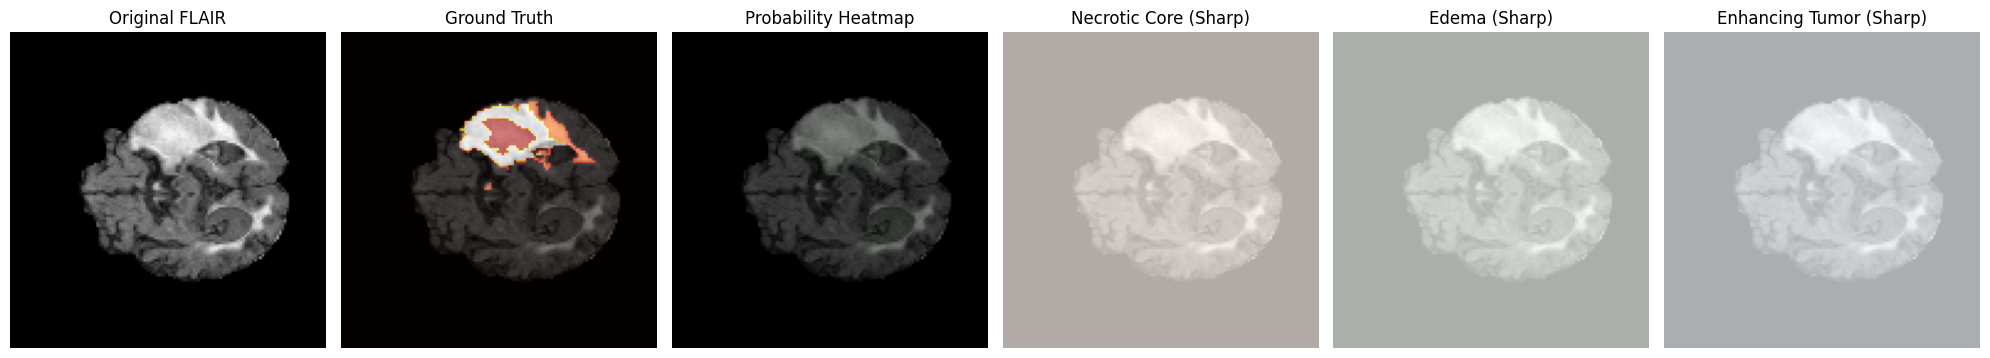


Dice Scores for slice 64:
Necrotic/Core: 0.000
Edema: 0.000
Enhancing: 1.000
Average: 0.333

Case BraTS20_Training_034
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step


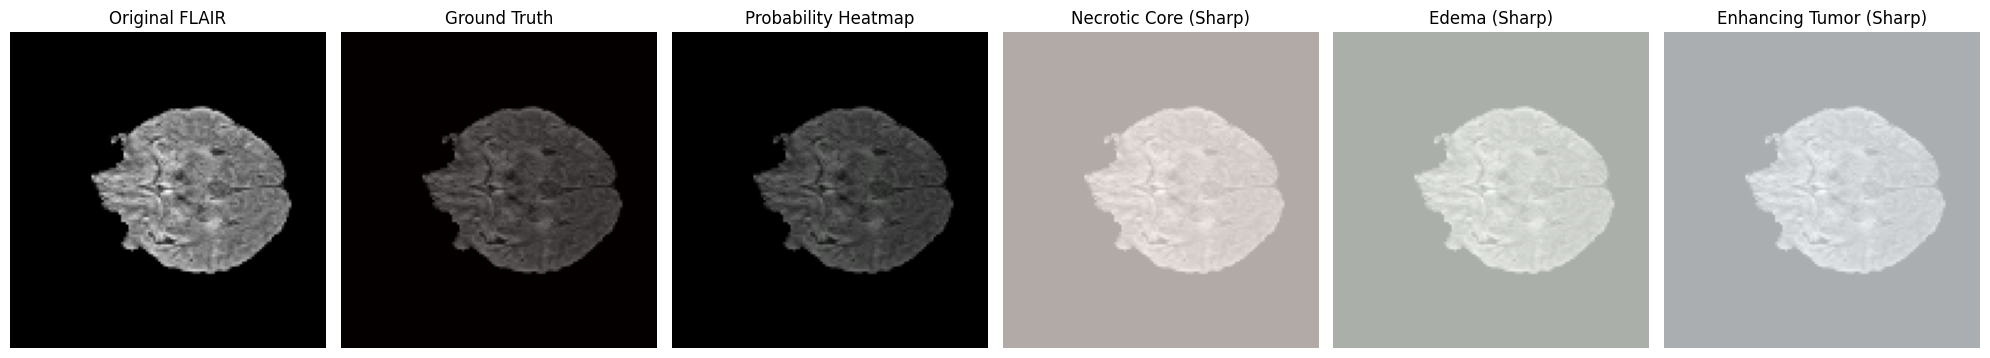


Dice Scores for slice 64:
Necrotic/Core: 1.000
Edema: 1.000
Enhancing: 1.000
Average: 1.000

Case BraTS20_Training_023
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step


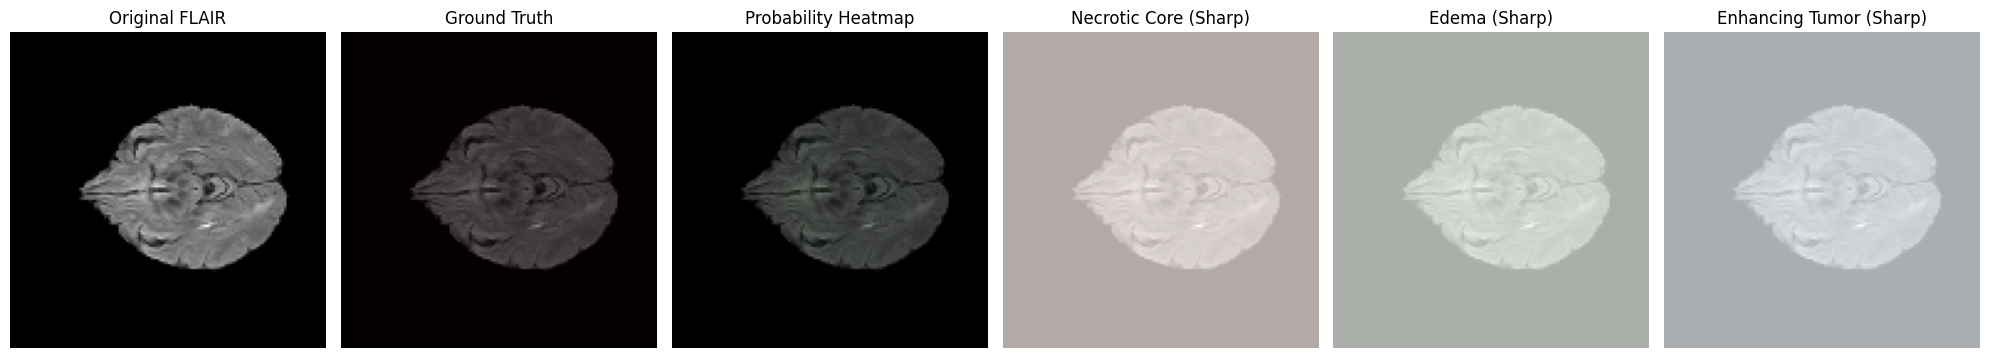


Dice Scores for slice 64:
Necrotic/Core: 1.000
Edema: 1.000
Enhancing: 1.000
Average: 1.000

Case BraTS20_Training_227
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step


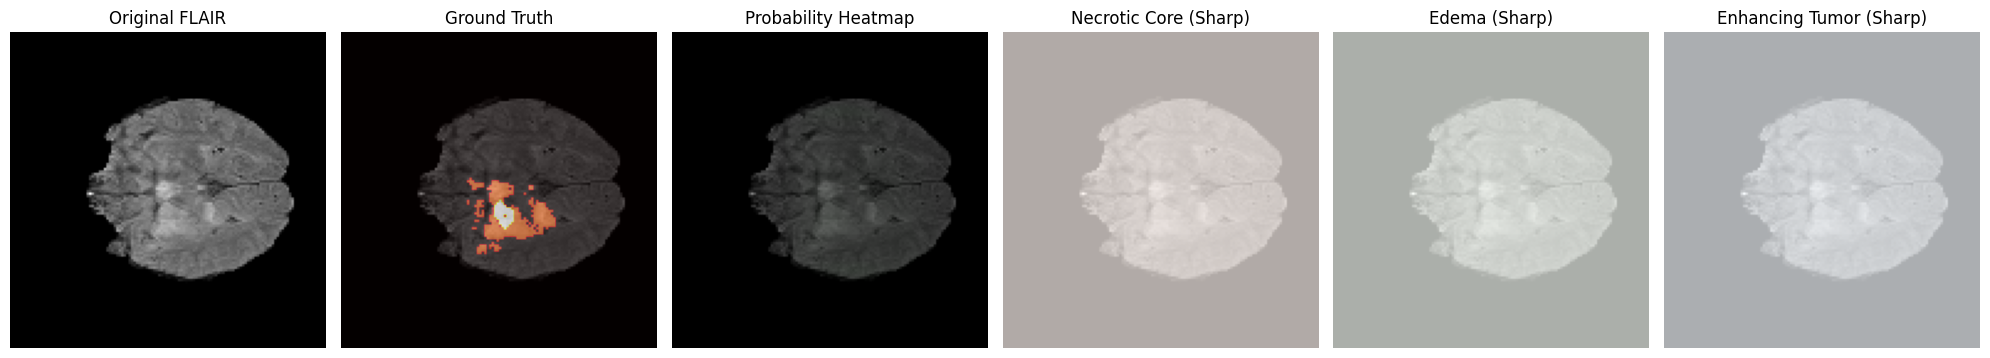


Dice Scores for slice 64:
Necrotic/Core: 0.000
Edema: 0.000
Enhancing: 1.000
Average: 0.333

Case BraTS20_Training_019
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step


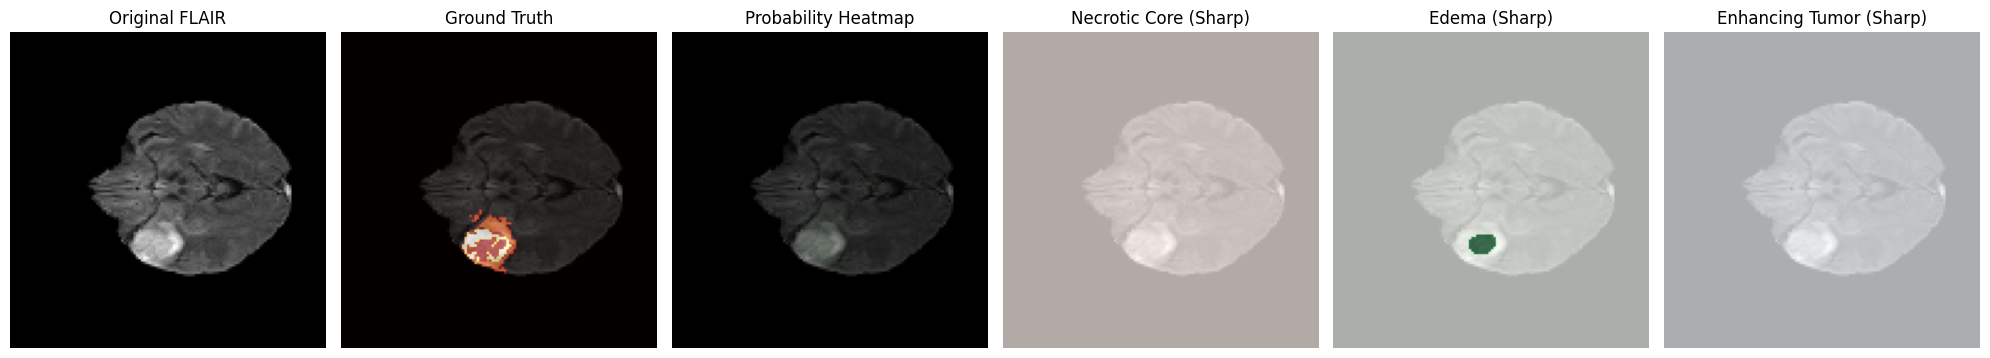


Dice Scores for slice 64:
Necrotic/Core: 0.000
Edema: 0.000
Enhancing: 1.000
Average: 0.333
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step


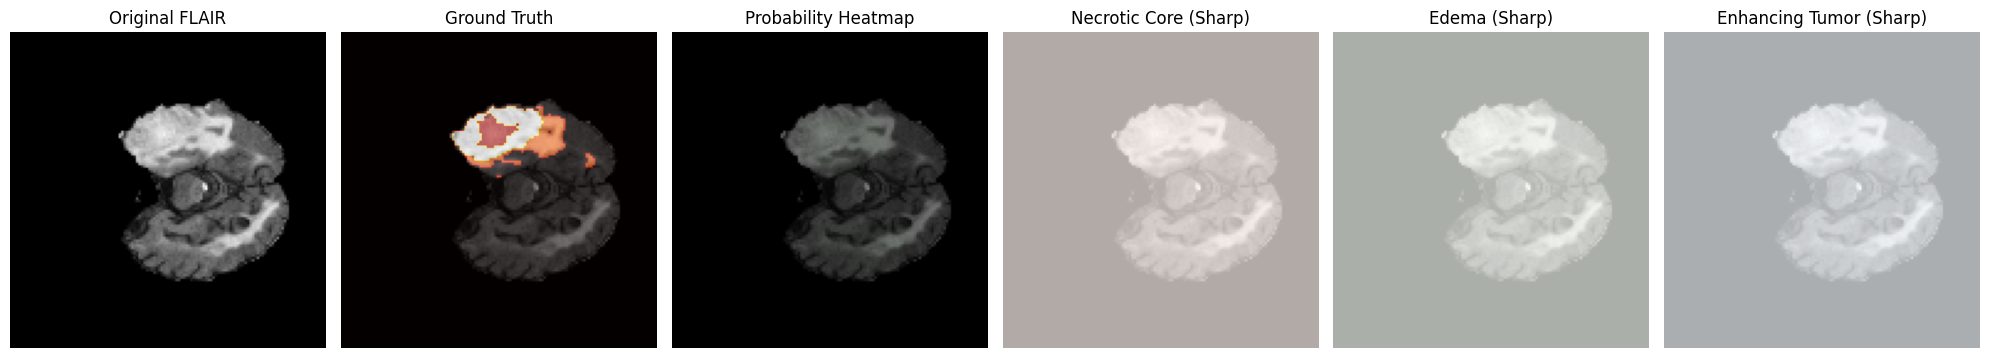


Dice Scores for slice 50:
Necrotic/Core: 0.000
Edema: 0.000
Enhancing: 1.000
Average: 0.333
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step


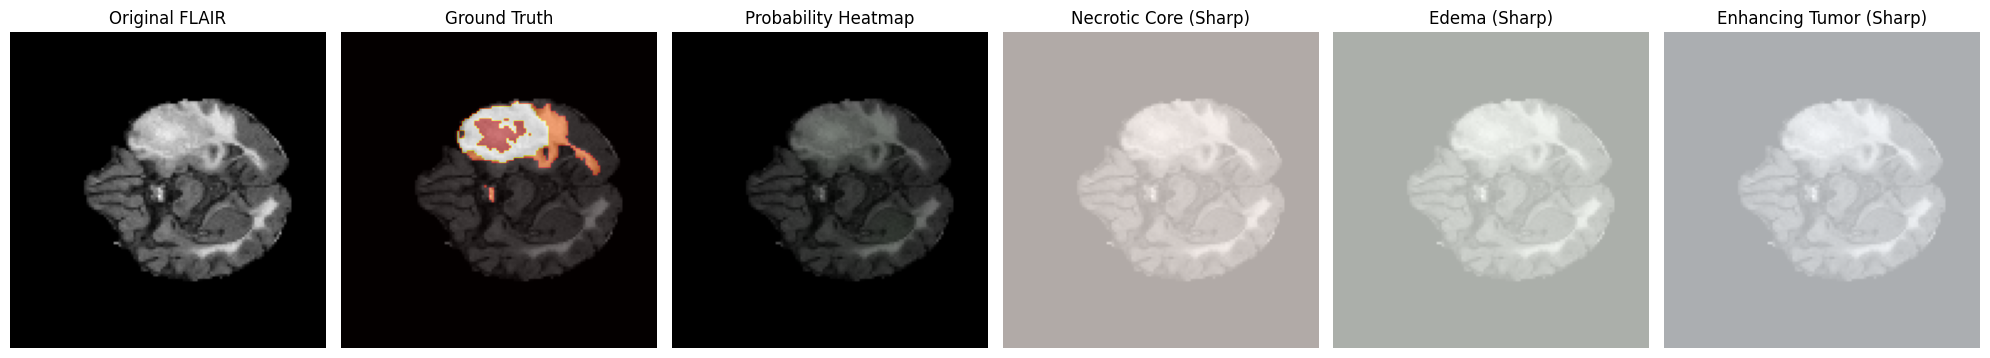


Dice Scores for slice 60:
Necrotic/Core: 0.000
Edema: 0.000
Enhancing: 1.000
Average: 0.333
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step


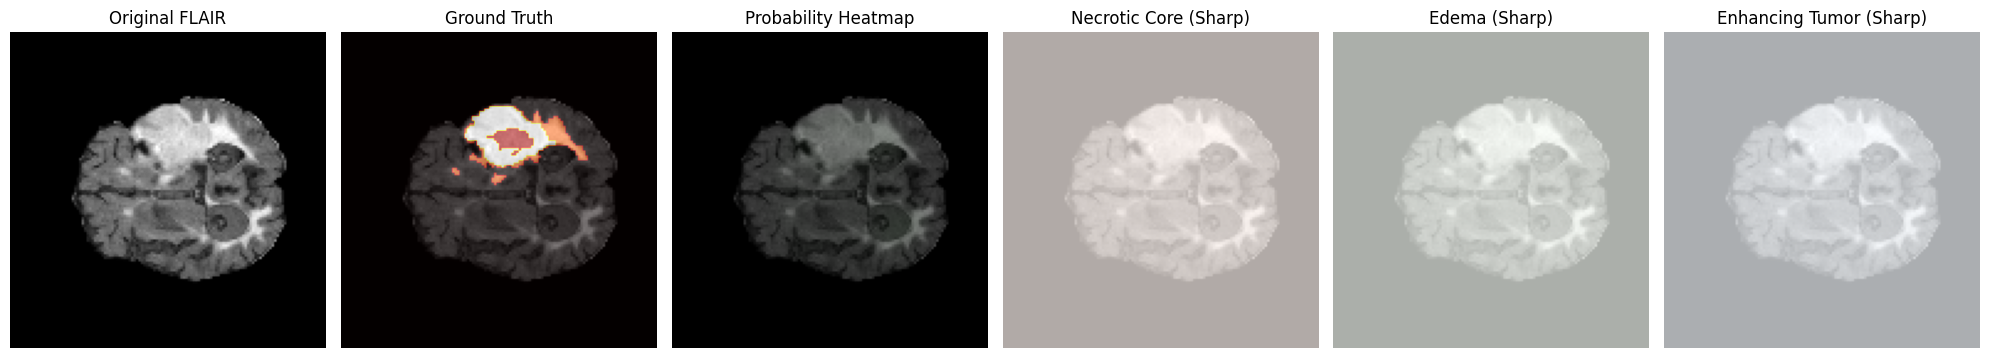


Dice Scores for slice 70:
Necrotic/Core: 0.000
Edema: 0.000
Enhancing: 1.000
Average: 0.333
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step


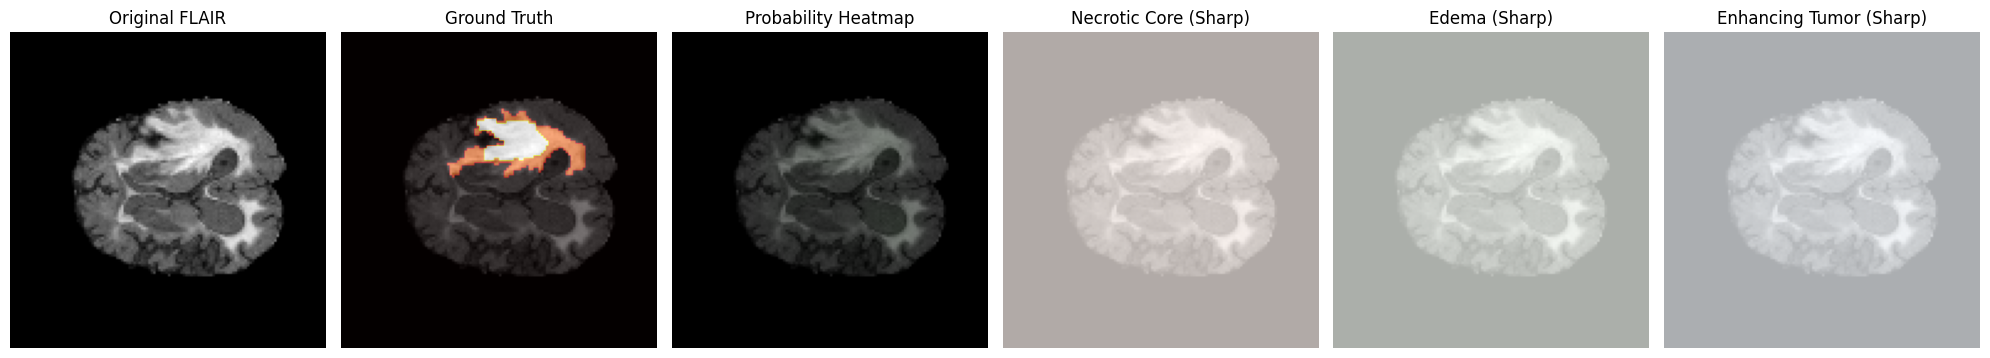


Dice Scores for slice 80:
Necrotic/Core: 0.000
Edema: 0.000
Enhancing: 1.000
Average: 0.333


In [174]:
for i in range(5):  # Show first 5 test cases
    print(f"\nCase {test_ids[i]}")
    showPredictsById(model, test_ids[i], TRAIN_DATASET_PATH)

case_id = test_ids[0]
for slice_idx in [50, 60, 70, 80]:  # View different slices
    showPredictsById(model, case_id, TRAIN_DATASET_PATH, start_slice=slice_idx)